# Tutorial for EEG Multisensory Perception and Imagination Dataset Processing

This tutorial provides a walkthrough for how to load, explore, prepare, pre-process and the multisensory perception and imagination dataset. After ICA the preprocessed files are saved in *.fif* format. This script is run for each subject and session separately. To automate processing of all subjects use the *batch-papermill.ipynb* notebook.

1. Loading Data
2. Exploring Data
    - a. Plotting the raw data, including power spectrum density
    - b. Montage visualisation
3. Cleaning Data
    - a. Detecting and Dealing with Bad channels
    - b. Common Average Rereferencing
    - c. Filtering out power noise and low frequency drifts.
    - d. Finding Components using ICA
    - e. Automatically removing electrophysiological artifacts
4. Saving Data as .fif

## The Dataset
This dataset has been created at the University of Bath, and collected by Holly Wilson, Jinha Yoon, Becky Dakin and Aneekha Bal. We use a 128 channel gel-based ANT-Neuro headset. Data is recorded at 1024 *Hz*. The amount of trials undertaken by participants varied as a function of their fatigue. Many participants requested to finish before completing the full experiment. Additionally, though all participants are requested to complete three sessions, the majority of participants completed 1-2 sessions. A baseline recording is taken during the 10 second countdown to the first trial, after the participant presses a space bar to begin the experiment. Breaks occur roughly every 7 minutes. The three semantic categories used are 'penguin', 'guitar' and 'flower'. The three sensory modalities include pictorial (visual), orthographic (visual) and speech (audio). The two tasks include perception and imagination. There are roughly 40 trials for each of the 18 conditions.



For further information regarding the experimental design, data collection and data preparation, contact hlw69@bath.ac.uk.  

In [19]:
# make sure you have mne, pandas, sklearn installed, you may also need pymatreader
import sys
import mne
from mne import preprocessing
import pandas as pd
from sklearn.model_selection import train_test_split
from mne.io import read_raw_eeglab
from mne.io import eeglab
import numpy as np
import os.path
from os import path
import pyprep

### Parameter Setting
Participant specific information we can set below, alongside numnber of ICA components to choose.
As the EOG and ECG artifacts are fairly strong, these artifacts should be captured in the first few dimensions of the PCA decomposition that happens before the ICA. "Therefore, we probably don’t need a huge number of components to do a good job of isolating our artifacts (though it is usually preferable to include more components for a more accurate solution)."

In [20]:

ica_components = 50
output_folder_root= 'X:\\CompSci\\ResearchProjects\\EJONeill\\Neuroimaging\\multisensoryeeg\\openNeuro\\sourcedata\\' # where the .fif files should be stored


In [21]:
# Parameters
ppt_num = "10"
session = "1"
cap_size = "L"
bad_chans = [] #can be entered manually or found automatically


## (1) Loading Data
The eeg files are originally saved as a .cdf format specific to ANT-Neuro, it is not the same as the .cdf BrainVision formats. This means it cannot be directly loaded into python using mne. To make it compatiable, we first loaded it into EEGLAB then saved as a .set and .fdt file. The .fdt files contains the event information. However to load the data with mne we only need to call the .set file, as long as the .fdt is in the same folder it is loaded automatically alongside .set. Information about the events are captured as Annotations, which are different from Events. We later convert to Events, but note that there are differences, annotations units are seconds whereas Events are samples.

It is wise to sanity check properties of the data such as the sampling rate (should be 1024 hz), number of channels (should be 128 to begin with, then less once ECOG removed). 

Below we load the raw data, look at some of he information, and remove redundant electroculogram (EOG) electrodes. These electrodes, which are on long wires, are sometimes used for artifact removal or eye related movements. However, in our study we wanted to minimise any cables interfering with visual perception, therefore these electrodes were moved out of the way.

In [22]:
pathdata = 'sub'+ppt_num+'_sess'+session+ '\\sub'+ppt_num+'_sess'+session+'.set' 
xpath = 'X:\\CompSci\\ResearchProjects\\EJONeill\\Neuroimaging\\'
pathdata = xpath + pathdata
eog =  ['VEOGL', 'VEOGU', 'HEOGR', 'HEOGL'] # electroculogram electrodes 
if path.exists(pathdata):
    raw = read_raw_eeglab(pathdata,preload=True, eog=eog) # creates two types, eeg and eog
    print(raw)
    print(raw.info)
    raw.pick_types(eog=False, eeg=True) # ignore eog channels
    print('Sample rate of the data is:', raw.info['sfreq'], 'Hz. It should be 1024 Hz')
else:
    
    print("There is not .set file for subject-session ", ppt_num, session)
    sys.exit()

Reading X:\CompSci\ResearchProjects\EJONeill\Neuroimaging\sub10_sess1\sub10_sess1.fdt
Reading 0 ... 4958827  =      0.000 ...  4842.604 secs...


C:\Users\hlw69\AppData\Local\Temp\ipykernel_10920\3096093443.py:6: RuntimeWarning: Not setting positions of 4 eog channels found in montage:
['HEOGR', 'HEOGL', 'VEOGU', 'VEOGL']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_eeglab(pathdata,preload=True, eog=eog) # creates two types, eeg and eog


<RawEEGLAB | sub10_sess1.fdt, 128 x 4958828 (4842.6 s), ~4.73 GB, data loaded>
<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fpz, Fp2, F7, F3, Fz, F4, F8, FC5, FC1, FC2, FC6, M1, T7, ...
 chs: 124 EEG, 4 EOG
 custom_ref_applied: False
 dig: 124 items (124 EEG)
 highpass: 0.0 Hz
 lowpass: 512.0 Hz
 meas_date: unspecified
 nchan: 128
 projs: []
 sfreq: 1024.0 Hz
>
Sample rate of the data is: 1024.0 Hz. It should be 1024 Hz


### Plot intial PSD

Effective window size : 2.000 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.2s finished
C:\Users\hlw69\AppData\Local\Temp\ipykernel_10920\2496867906.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  initial_psd = raw.plot_psd(fmin = 0,fmax=100, n_fft=2048, spatial_colors=True)


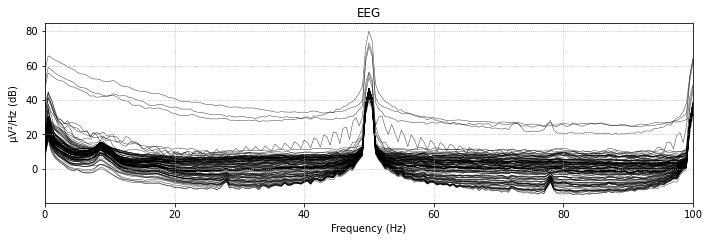

In [23]:
#initial_psd = raw.plot_psd(fmin = 0,fmax=100, n_fft=2048, spatial_colors=True)

# (2) Exploring the Data
##  2.a Plotting the Raw Data
We need to plot the data to sanity check that it looks as we would expect. We also plot the data to check for artifacts, as discussed in the next step. Note that when plotting, EEG channels are black, whereas MEG are blue. This means your plots will look different to some of the online tutorials. Your plots will not automatically be interactive. To make them so, use %matplotlib qt on the preceeding line.This will enable you to scroll through your plots. Note that this will not be possible if you are running the notebook from hex cluster.

Plot_psd plots the power spectral density, it can be considered as a histrogram for frequency information. You may see a spike around 50-60Hz, which is likely due to powerlines. We later filter this out.

Negative values on the decibal scale mean the power is less than the reference power. Higher decibal values mean a more powerful signal.

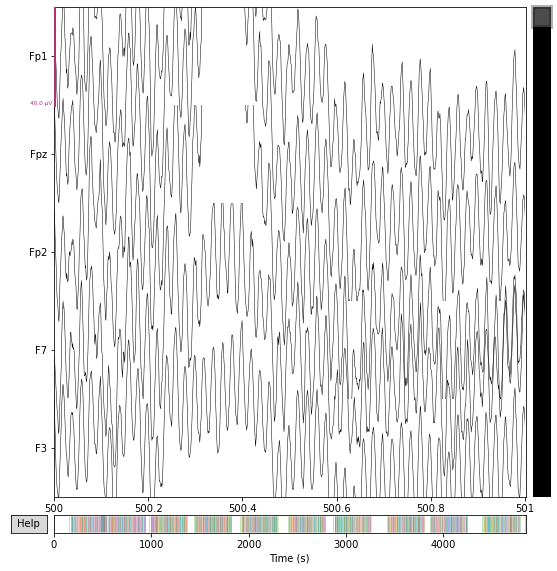

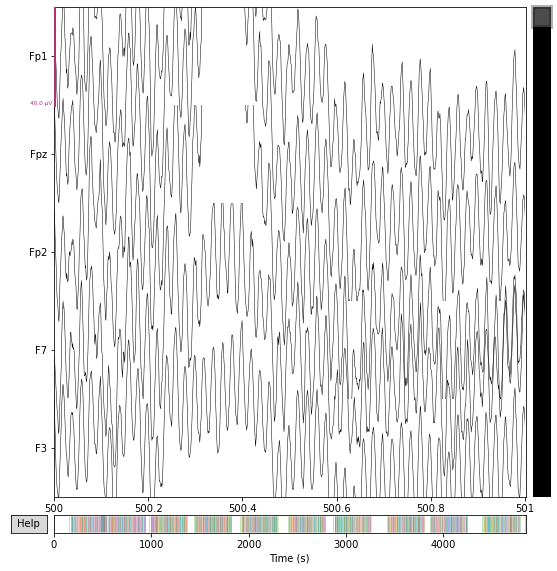

In [24]:

#raw.plot(duration=1, n_channels=5, start = 500 ) # input the timewindow and how many channels to include, 124 is eog removed
#fig = raw.plot(block=True, start = 200 )

## 2.b The Montage
It is useful to be able to visualise the layout of the electrodes when plotting data, and important to apply the montage to the raw data. Unfortunately ANT-Neuro montages, are particularly tricky to work with as they are not designed to be used in EEGLAB or mne. I am still working on making the montage fully compatiable. For now we have a rough montage to work with which is sufficient for visualisation. We are using roughly a 10/20 format. 

To get an indication of what the montage looks like, you can plot this in 2D and 3D. We set the montage of the raw data, to be the ANT-Montage that we have loaded up.

Posts related to the problem (mostly for me to go about fixing this !)
 https://github.com/mne-tools/mne-python/issues/5661;  https://mne.tools/stable/auto_tutorials/intro/40_sensor_locations.html
 https://sccn.ucsd.edu/pipermail/eeglablist/2011/003759.html

The **channel names** used: ['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'M1', 'T7', 'C3', 'Cz', 'C4', 'T8', 'M2', 'CP5', 'CP1', 'CP2', 'CP6', 'P7', 'P3', 'Pz', 'P4', 'P8', 'POz', 'O1', 'O2', 'HEOGR', 'AF7', 'AF3', 'AF4', 'AF8', 'F5', 'F1', 'F2', 'F6', 'FC3', 'FCz', 'FC4', 'C5', 'C1', 'C2', 'C6', 'CP3', 'CP4', 'P5', 'P1', 'P2', 'P6', 'HEOGL', 'PO3', 'PO4', 'VEOGU', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'VEOGL', 'FT9', 'FT10', 'TPP9h', 'TPP10h', 'PO9', 'PO10', 'P9', 'P10', 'AFF1', 'AFz', 'AFF2', 'FFC5h', 'FFC3h', 'FFC4h', 'FFC6h', 'FCC5h', 'FCC3h', 'FCC4h', 'FCC6h', 'CCP5h', 'CCP3h', 'CCP4h', 'CCP6h', 'CPP5h', 'CPP3h', 'CPP4h', 'CPP6h', 'PPO1', 'PPO2', 'I1', 'Iz', 'I2', 'AFp3h', 'AFp4h', 'AFF5h', 'AFF6h', 'FFT7h', 'FFC1h', 'FFC2h', 'FFT8h', 'FTT9h', 'FTT7h', 'FCC1h', 'FCC2h', 'FTT8h', 'FTT10h', 'TTP7h', 'CCP1h', 'CCP2h', 'TTP8h', 'TPP7h', 'CPP1h', 'CPP2h', 'TPP8h', 'PPO9h', 'PPO5h', 'PPO6h', 'PPO10h', 'POO9h', 'POO3h', 'POO4h', 'POO10h', 'OI1h', 'OI2h']

**F** indicates *frontal*.    **O** indicates *occipital*.     **P** indicates *parietal*.   **C** indicates *central*.   **FP**  is *Prefrontal*. **T** is *temporal*.   **M** is *mastoid*.



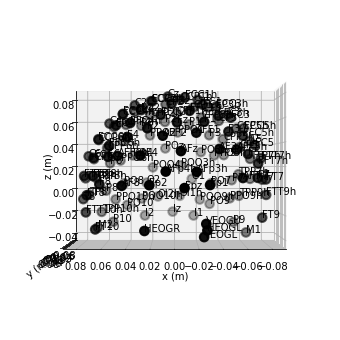

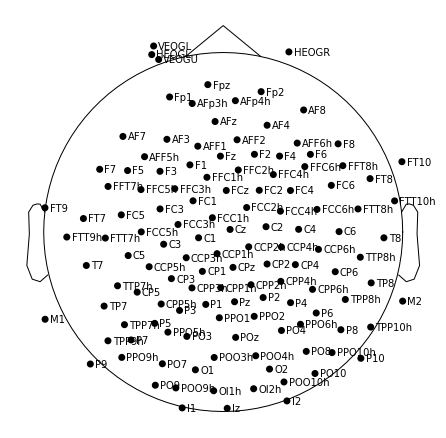

<RawEEGLAB | sub10_sess1.fdt, 124 x 4958828 (4842.6 s), ~4.58 GB, data loaded>

In [25]:
from mne import channels
#montage = channels.read_dig_hpts('C:\\Users\\hlw69\\Documents\\eeg_experiment\\Experiment\\CA-203.hpts')
montage_path = 'X:\\CompSci\\ResearchProjects\\EJONeill\\Neuroimaging\\montages\\'
#read_montage(kind = 'antNeuroMontage',path = 'C:\\Users\\hlw69\\Documents\\eeg_experiment\\Experiment\\antNeuroMontage.txt')
ant_montage = channels.read_custom_montage(montage_path+'edit.loc', coord_frame = 'head',head_size=0.08)#

#layout_from_raw = mne.channels.make_eeg_layout(raw.info)
fig = ant_montage.plot(kind='3d')
#fig.gca().view_init(azim=70, elev=15)  # set view angle
ant_montage.plot(kind='topomap', show_names=True)
raw.set_montage(ant_montage)
# raw.plot_sensors(ch_type='eeg')


### Mark bads and then re-reference to Common Average
Our reference during recording was CPz, we now use common average referencing which has been shown to reduce noise, and is the average of all electrodes. then subtracted from each electrode.

In [26]:
from pyprep.prep_pipeline import PrepPipeline
import pyprep

nc = pyprep.find_noisy_channels.NoisyChannels(raw)
nc.find_all_bads(ransac=False)


Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 3381 samples (3.302 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 124 out of 124 | elapsed:   27.7s finished


In [27]:
bads = nc.get_bads()
print(bads)
print(type(bads))
#bads.remove('CPz')
#print()

print("bad channels obtained by pyprep are: ", bads)
#bads += []
# remove CPZ from bads
raw.info['bads'] += bads

['C5', 'FCC3h', 'CP3', 'CPP1h', 'M1', 'CCP2h', 'CCP1h', 'CPP3h', 'POO3h', 'PO3', 'CP2']
<class 'list'>
bad channels obtained by pyprep are:  ['C5', 'FCC3h', 'CP3', 'CPP1h', 'M1', 'CCP2h', 'CCP1h', 'CPP3h', 'POO3h', 'PO3', 'CP2']


In [28]:
# Reference in our case is CPz. but we use common average referencing. First we add back in the old reference channel as flat channel
#raw = mne.add_reference_channels(raw, 'CPz', copy=False)
raw = raw.set_eeg_reference(ref_channels='average')

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


Effective window size : 2.000 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.5s finished


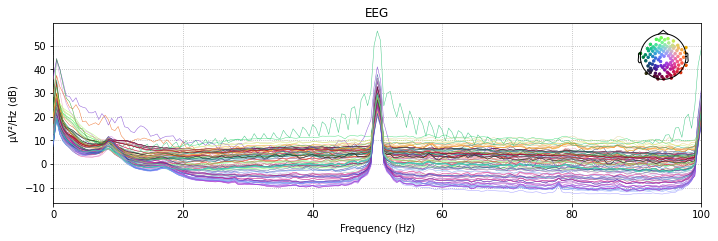

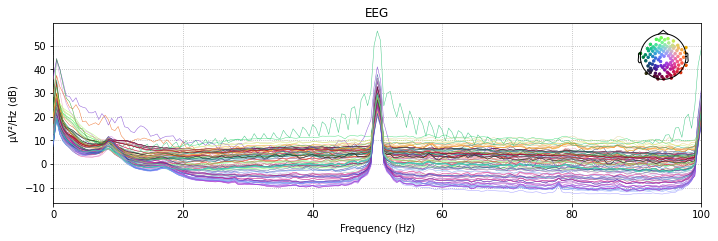

In [29]:
#raw.plot_psd(fmin = 0,fmax=100, n_fft=2048, spatial_colors=True)

In [30]:
raw.describe()

<RawEEGLAB | sub10_sess1.fdt, 124 x 4958828 (4842.6 s), ~4.58 GB, data loaded>
 ch  name    type  unit        min         Q1     median         Q3        max
  0  Fp1     EEG   µV     -7177.82   -5490.64   -3107.26   -1895.86      55.96
  1  Fpz     EEG   µV     -7019.95   -5048.92   -3996.84   -2970.57   -1543.97
  2  Fp2     EEG   µV    -11357.88   -9218.18   -8219.17   -7498.46   -5626.10
  3  F7      EEG   µV    -51327.32    7098.36    7319.40    7641.42   60687.24
  4  F3      EEG   µV       968.67    1670.07    1892.29    2034.08    2625.51
  5  Fz      EEG   µV       111.84     752.69     963.56    1124.74    1767.15
  6  F4      EEG   µV     -7485.43   -5702.20   -4749.74   -4271.52   -3591.77
  7  F8      EEG   µV     -2575.30    -479.84     901.16    1455.72    3183.37
  8  FC5     EEG   µV     -2852.44   -1531.69    -940.83    -561.84     933.00
  9  FC1     EEG   µV     -2600.42   -1208.61    -678.93    -499.83     136.43
 10  FC2     EEG   µV     -6049.58   -5611.76   -524

# (3) Cleaning the Data
## 3.a Detecting and Dealing with Bad Channels
We can look for bad channels by plotting them. Ones whch are completely flat indicate that the electrode was broken or impedance was insufficient to record a signal. These ones we should remove. We can fill in the missing data this creates by performing interpolation later on. Channels might also be bad due to having a significantly noiser signal than others. We could remove these, or we can leave them in and rely on ICA to deal with this in a later stage which means the whole channel does not have to be removed. So we can either remove, ignore or repair bad channels. It is important though, to at minimum, annotate channels which are bad.

Note that channel CCP1h is broken on the Large cap, so if the participant had the Large cap, always remove this particular channel.

#** This step needs to happen prior to re-referencing using common average referencing

### Bad channel Automated Detection methods
- find by correlation
- find by SNR
- find by deviation (abnormally high or low amplitudes)
- find by hf noise (channels with abnormally high frequency noise)
- find by nan flat (near-flat signals)
- find by ransac, ransac might be too aggressive


# The problem is with the CPz, after pyprep and interpolation it ends up as NaN values, again. This needs to be fixed.
Consider removing it from the list of bad channels

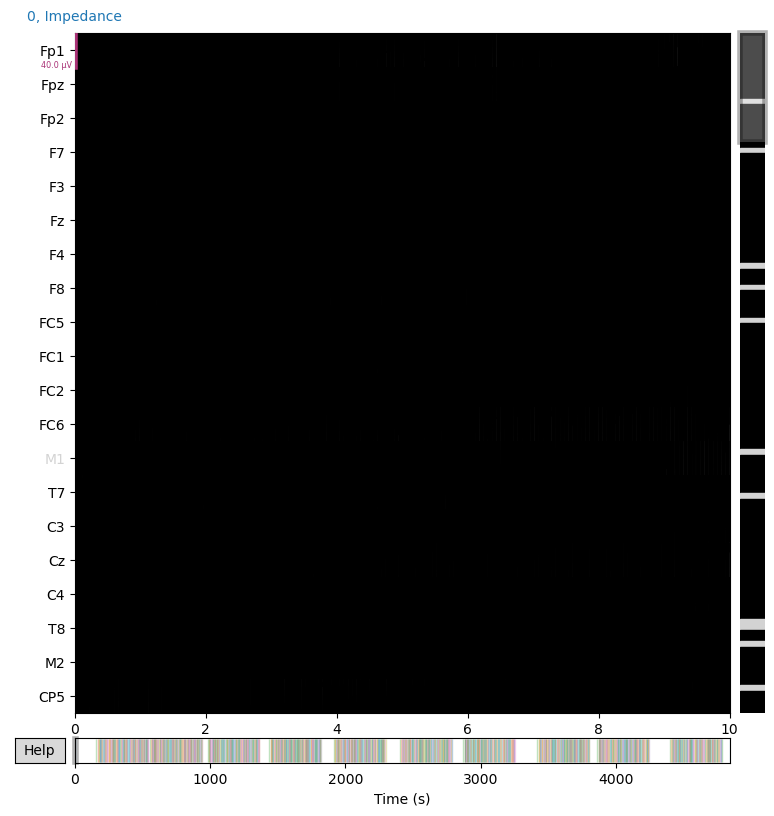

In [31]:
#%matplotlib qt
#raw.plot()

In [32]:
print("Before interpolation, the bad channels include: ", raw.info['bads'])
#picks = mne.pick_types(raw.info, exclude='bads')  # picks can then be taken into epochs
raw = raw.interpolate_bads(reset_bads=True)  # interpolate for the bad channel to fill in the missing data
print("after interpolation this list should be empty", raw.info['bads'])

Before interpolation, the bad channels include:  ['C5', 'FCC3h', 'CP3', 'CPP1h', 'M1', 'CCP2h', 'CCP1h', 'CPP3h', 'POO3h', 'PO3', 'CP2']
Interpolating bad channels
    Automatic origin fit: head of radius 80.0 mm
Computing interpolation matrix from 113 sensor positions
Interpolating 11 sensors
after interpolation this list should be empty []


In [33]:
#%matplotlib qt

#raw.plot()

In [34]:
nans = mne.preprocessing.annotate_nan(raw, verbose=True)

In [35]:
print(nans)

<Annotations | 0 segments>


In [36]:
#%matplotlib qt

#raw.plot()

In [37]:
#raw.describe()

<RawEEGLAB | sub10_sess1.fdt, 124 x 4958828 (4842.6 s), ~4.58 GB, data loaded>
 ch  name    type  unit        min         Q1     median         Q3        max
  0  Fp1     EEG   µV     -7177.82   -5490.64   -3107.26   -1895.86      55.96
  1  Fpz     EEG   µV     -7019.95   -5048.92   -3996.84   -2970.57   -1543.97
  2  Fp2     EEG   µV    -11357.88   -9218.18   -8219.17   -7498.46   -5626.10
  3  F7      EEG   µV    -51327.32    7098.36    7319.40    7641.42   60687.24
  4  F3      EEG   µV       968.67    1670.07    1892.29    2034.08    2625.51
  5  Fz      EEG   µV       111.84     752.69     963.56    1124.74    1767.15
  6  F4      EEG   µV     -7485.43   -5702.20   -4749.74   -4271.52   -3591.77
  7  F8      EEG   µV     -2575.30    -479.84     901.16    1455.72    3183.37
  8  FC5     EEG   µV     -2852.44   -1531.69    -940.83    -561.84     933.00
  9  FC1     EEG   µV     -2600.42   -1208.61    -678.93    -499.83     136.43
 10  FC2     EEG   µV     -6049.58   -5611.76   -524

Effective window size : 2.000 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.6s finished


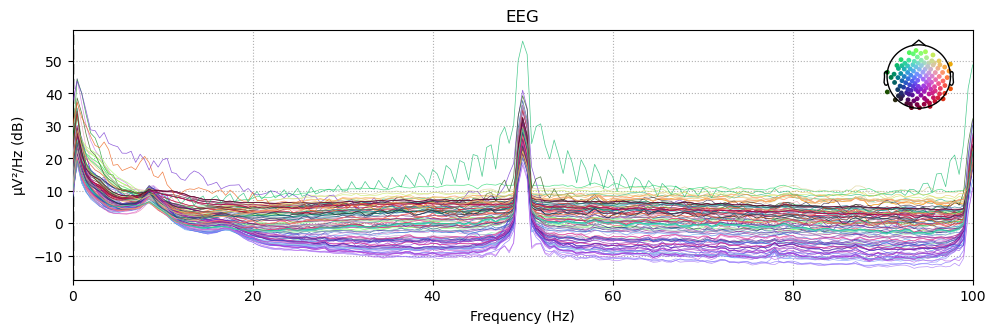

In [38]:
#raw.plot_psd(fmin = 0,fmax=100, n_fft=2048, spatial_colors=True) # y is decibals and x is frequency

### Re-reference Again
As channels have been altered

In [49]:
raw = raw.set_eeg_reference(ref_channels='average')
#raw.describe()

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


## Filtering


We filter the data to remove power-line noise (*50 Hz*) via notch filtering, and then remove low-frequency drifts. Power-line noise can also be present at harmonic frequencies, hence we remove at 50, 100, 150Hz.
Low frequency noise arises from movements of the head, and also wires, as well as scalp perspiration. In contrast, high frequency noise relates to face and neck muscles as well as electromagnetic interference. We can choose whethe to remove low-frequence drifts, i.e. DC drifts.


In [40]:
notches = np.array([50, 100, 150])
raw.notch_filter(freqs = notches, picks = 'eeg',  filter_length = 'auto', phase = 'zero-double', fir_design = 'firwin')
filtered_psd = raw.plot_psd(fmin = 0,fmax=100, n_fft=2048, spatial_colors=True) # y is decibals and x is frequency

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 124 out of 124 | elapsed:   18.7s finished


Effective window size : 2.000 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.1s finished


In [41]:
raw.filter(l_freq=1., h_freq=None)
filtered_psd = raw.plot_psd(fmin = 0,fmax=100, n_fft=2048, spatial_colors=True) # y is decibals and x is frequency
filtered_psd.savefig(ppt_num+'_'+session+'_filtered_psd.png')

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 3381 samples (3.302 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 124 out of 124 | elapsed:   16.7s finished


Effective window size : 2.000 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.7s finished


### Re-reference Again

In [44]:
raw = raw.set_eeg_reference(ref_channels='average')

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


### 3.d Identify and Subtract Noise with ICA
We perform Independent Component Analaysis (ICA) initially to remove unwanted components from the data, though we can later use it to also reduce the dimensionality of our data. ICA unmixes separate sources (channels) of data. This can be performed on filtered or filtered and epoched data. Though we recommend fitting to raw data. The data should be high pass filtered before fitting, as ICA is sensitive to low-frequency drifts. However if ICA is fit on epoched data, then it is recommended to high-pass filter but not to baseline correct the data. There are three options for the ICA algorithm, fastica, picard or infomax. Here we use Fastica.

We try and avoid fitting ICA on environmental artifacts that would dominate the variance and decomposition

In [45]:
# first whitens the data, then obtains unmixing matrix, whitening the data means to uncorrelate the data
#reject = dict(mag=5e-12, grad=4000e-13) # this prevents ICA being fit on extreme environmental factors
amount_variance_explain = .99
ica = mne.preprocessing.ICA(n_components=ica_components, random_state=97, max_iter=800)#, method='picard')
ica.fit(raw)
#ica.exclude = []  # exclude components related to artifacts
#ica.plot_properties(raw)#, picks=ica.exclude)
#orig_raw = raw.copy()
#raw.load_data(preload=True )
#ica.apply(raw)
#ica_plot = ica.plot_components()
#ica_plot.savefig('ica_components.png')

#ica_raw = raw.plot_psd(fmin = 0,fmax=100, n_fft=2048, spatial_colors=True) # y is decibals and x is frequency
#ica_raw.savefig('ica_raw.png')


Fitting ICA to data using 124 channels (please be patient, this may take a while)
Selecting by number: 50 components
Fitting ICA took 582.3s.


Method,fastica
Fit,106 iterations on raw data (4958828 samples)
ICA components,50
Explained variance,99.4 %
Available PCA components,124
Channel types,eeg
ICA components marked for exclusion,—


In [ ]:
ica_plot = ica.plot_components(colorbar=True)

### 3.e Electrophysiological Artifacts

##### Ocular (EOG)
It is useful to visualise artifacts driven by eye muscles. As in the code below, we take a couple of the channels which are close to eyes *Fp1* and *Fp2*, to estimate eog activity. By estimating these artifacts, we can use these to reject components from ICA which seems to capture them. Eye components are generally blinks and horizontal eye movements. 
##### Muscular (EMG)
Muscle (electromyographical) activity, show up as having high power in high frequency bands, this activation is generally transient, so may just appear over a few trials. We cannot automatically estimate EMG activity unless we were using specific EMG electrodes, however we should be able to clean up EMG activity through ICA components. 

##### Heart Beat (ECG)
Similarly, we cannot estimate ECG activity in the way we can for EOG activity. Though again, we expect ECG activity to show up as in ICA components so we can remove it. ECG activity has a distinct pattern in the data.

Using EOG channels: Fp1, Fp2
EOG channel index for this subject is: [0 2]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10240 samples (10.000 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Now detecting blinks and generating corresponding events
Found 3533 significant peaks
Number of EOG events detected: 3533
Not setting metadata
3533 matching events found
No baseline correction applied
Using data from preloaded Raw for 3533 events and 1025 original time points ...


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


1 bad epochs dropped
Applying baseline correction (mode: mean)
No projector specified for this dataset. Please consider the method self.add_proj.


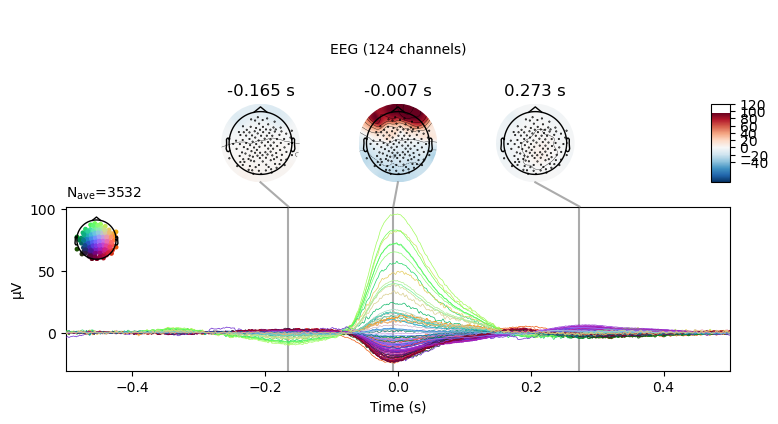

In [46]:
from mne.preprocessing import create_ecg_epochs, create_eog_epochs
#average_ecg = create_ecg_epochs(raw).average() # heart beats! cannot do unless meg
eog_evoked = preprocessing.create_eog_epochs(raw, ch_name = ['Fp1', 'Fp2']).average()
eog_evoked.apply_baseline(baseline=(None, -0.2))
eog_evoked.plot_joint()


Using EOG channels: Fp1, Fp2


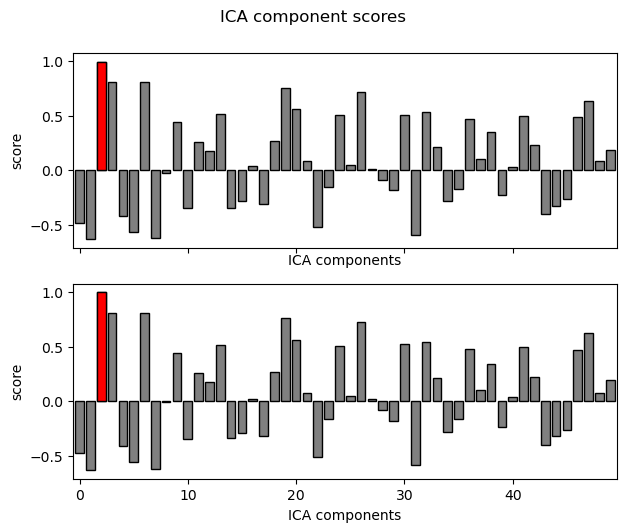

In [47]:
# https://mne.discourse.group/t/how-many-ica-components-represent-blink-artifacts/3097/6

#Here we use the EOG components we estimated earlier, and remove them from the data
ica_z_thresh = 1.96 
eog_indices, eog_scores = ica.find_bads_eog(eog_evoked, 
                                            ch_name=['Fp1', 'Fp2'], 
                                            threshold=ica_z_thresh)

# we can't do the same with muscles as the function is on the unstable development version of mne
#muscle_idx_auto, scores = ica.find_bads_muscle(raw)

#ecg_indices, ecg_scores = ica.find_bads_ecg(average_ecg,threshold='zscore')
#muscle_indices, muscle_scores = ica.find_bads_muscle(average_muscle,threshold='zscore')
ica.exclude = eog_indices
#ica.exclude = ecg_indices #ica.exclude = muscle_indices

ica.plot_scores(eog_scores) # rejected ones are in red
#ica.plot_scores(ecg_indices)  #ica.plot_scores(muscle_indices) 

Now we apply the ICA to the raw data, we end up with the same dimensionality of data as before but with artifact components removed.

In [48]:
dimension_to_keep = 124
ica.apply(raw, n_pca_components = dimension_to_keep)

sources = ica.plot_sources(raw, start=80, stop=90)
#properties = ica.plot_properties(raw)#, picks=ica.exclude)
sources.savefig(ppt_num+'_'+session+'_'+str(ica_components)+'_sources.png',overwrite=True)

#from autoreject import get_rejection_threshold
#reject = get_rejection_threshold(epochs_ica);


Applying ICA to Raw instance
    Transforming to ICA space (50 components)
    Zeroing out 1 ICA component
    Projecting back using 124 PCA components
Creating RawArray with float64 data, n_channels=50, n_times=4958828
    Range : 0 ... 4958827 =      0.000 ...  4842.604 secs
Ready.


C:\Users\hlw69\AppData\Local\Temp\ipykernel_10920\1364357886.py:6: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "overwrite" which is no longer supported as of 3.3 and will become an error in 3.6
  sources.savefig(ppt_num+'_'+session+'_'+str(ica_components)+'_sources.png',overwrite=True)


### Save Processed Data in native mne format .fif, prior to epoching

In [ ]:
preprocessname = output_folder_root + 'sub'+ppt_num+'_sess'+session+'_'+str(ica_components)+'_ica_eeg.fif'
raw.save(fname = preprocessname, overwrite=True)
